In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('./data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    speed_all2 = speed_all.copy()
    # Day of Week => monday : 0, sunday : 6
    speed_all2['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all2['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all2.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all2.groupby(['weekday', 'timestamp']).std()
    
    speed_all2 = speed_all2.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all2, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [4]:
accident_all['accident_sid'].value_counts()[:10]

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
1130006501    10
1190000200     9
1020000902     9
1220005502     8
1210005402     8
Name: accident_sid, dtype: int64

In [5]:
    target_sid = 1210005301      ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

        df_all_norm = df_all_norm.rolling(12).mean()

#     # define anomaly label
#     labels = []
#     accident_case['created'] = pd.to_datetime(accident_case['created'])
#     for ix, row in accident_case.iterrows():
#         accident_created = row['created']
#         min = accident_created.minute % 5
#         sec = accident_created.second
#         accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
#         labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
#     labels = list(map(int, (np.sum(labels, axis=0) > 0)))
#     label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

In [6]:
# from datasets.Myloader import traffic_loader

# train_loader, val_loader, test_loader = traffic_loader(args, target_sid)
# len(train_loader), len(val_loader), len(test_loader)

In [7]:
## smoothing
rolling_window = 6
speed_all = speed_all.rolling(rolling_window).mean()
# speed_all = speed_all.iloc[rolling_window-1:]

## nan value
speed_all = speed_all.bfill(limit=36).ffill(limit=36).fillna(0, limit=288*10)#.dropna(axis=1)

In [8]:
speed_all.shape

(51840, 26)

In [9]:
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [10]:
# df_agg_inflow, df_agg_outflow = [], []
# for hop in [0, 1, 2, 3]:
#     inflow = np.unique([p[hop] for p in path_inflow])
#     outflow = np.unique([p[hop] for p in path_outflow])
#     df_agg_inflow.append(speed_all[inflow].mean(axis=1))
#     df_agg_outflow.append(speed_all[outflow].mean(axis=1))
# df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
# df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

## Detect Congestion

### accident road

In [9]:
ff_speed = speed_all.quantile(q=0.90, axis=0)
cong_speed = ff_speed * 0.6
ff_speed, cong_speed

(sid
 1210004801     79.404046
 1210004802     89.652873
 1210005304    104.137985
 1210005305    104.273915
 1210065700     71.094556
 1210066100     64.040266
 1210066300     59.616381
 1220004700     40.070247
 1220095000     52.945226
 1220096900     57.911081
 1220342100     48.404164
 1220342500    104.397419
 1220342700     78.759407
 1020026801     51.042692
 1020056400     77.492314
 1210004500     96.373359
 1210004901     94.733181
 1210004902     86.594552
 1210005402     98.090156
 1210060300     76.431230
 1210062100     39.620123
 1210062500     48.643593
 1210062700     68.107427
 1210158699     37.863541
 1210160799     36.484535
 1210005301     90.742726
 Name: 0.9, dtype: float64,
 sid
 1210004801    47.642427
 1210004802    53.791724
 1210005304    62.482791
 1210005305    62.564349
 1210065700    42.656734
 1210066100    38.424160
 1210066300    35.769829
 1220004700    24.042148
 1220095000    31.767136
 1220096900    34.746649
 1220342100    29.042499
 1220342500

In [10]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12][target_sid]
    if ts.mean() < cong_speed[target_sid]:
        congestion_label.iloc[i+12] = 1
        

KeyboardInterrupt: 

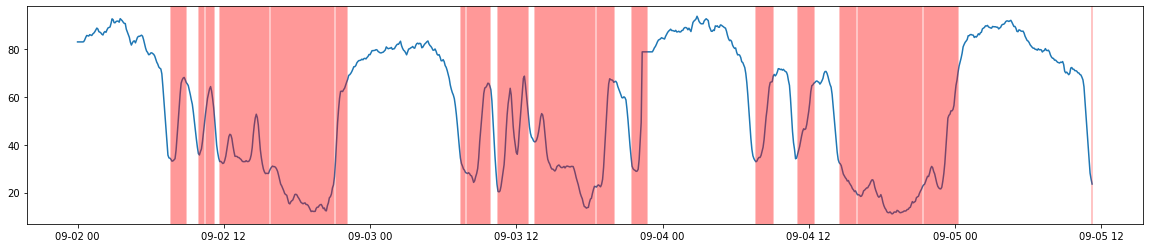

In [20]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:1000][target_sid])

for i in range(1000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

In [35]:
ff_speed = df_all_norm.quantile(q=0.90, axis=0)
cong_speed = ff_speed * 0.6
ff_speed, cong_speed

(sid
 1210004801    0.841744
 1210004802    0.947643
 1210005304    1.260895
 1210005305    1.133743
 1210065700    1.194300
 1210066100    1.074664
 1210066300    1.068976
 1220004700    0.942634
 1220095000    1.114306
 1220096900    1.077937
 1220342100    1.303062
 1220342500    1.099413
 1220342700    1.097080
 1020026801    1.164800
 1020056400    1.334973
 1210004500    1.075582
 1210004901    1.148415
 1210004902    1.321754
 1210005402    1.143608
 1210060300    0.815556
 1210062100    1.226841
 1210062500    1.458530
 1210062700    1.297912
 1210158699    1.025949
 1210160799    1.324909
 1210005301    1.287048
 Name: 0.9, dtype: float64,
 sid
 1210004801    0.505047
 1210004802    0.568586
 1210005304    0.756537
 1210005305    0.680246
 1210065700    0.716580
 1210066100    0.644799
 1210066300    0.641386
 1220004700    0.565580
 1220095000    0.668583
 1220096900    0.646762
 1220342100    0.781837
 1220342500    0.659648
 1220342700    0.658248
 1020026801    0.698880
 1

In [22]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(df_all_norm)-12):
    ts = df_all_norm[i:i+12][target_sid]
    if ts.mean() < cong_speed[target_sid]:
        congestion_label.iloc[i+12] = 1
        

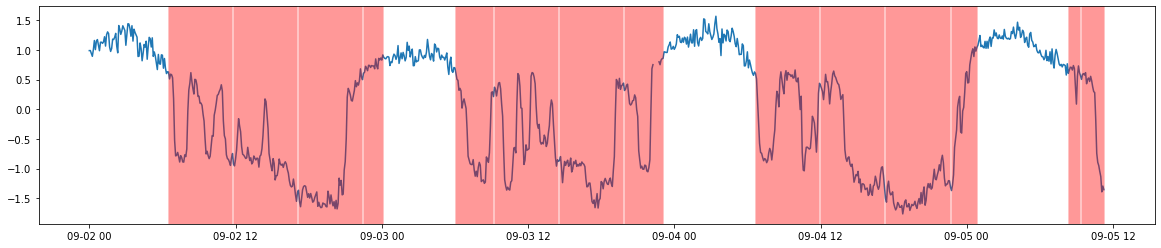

In [23]:
plt.figure(figsize=(20,4))
plt.plot(df_all_norm[:1000][target_sid])

for i in range(1000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

### all roads

In [24]:
(speed_all[i:i+12].mean(axis=0) < cong_speed).sum()

10

In [25]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.5*speed_all.shape[1]:
        congestion_label.iloc[i+12] = 1
        

In [12]:
## hop1까지만 고려

ff_speed = speed_all.quantile(q=0.90, axis=0)
cong_speed = ff_speed * 0.6
# ff_speed, cong_speed


hop1 = [p[1] for p in path_inflow]
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    n_cong_road = (ts[hop1].mean(axis=0) < cong_speed[hop1]).sum()
    if n_cong_road > 0.5*len(hop1):
        congestion_label.iloc[i+12] = 1
        

In [50]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
    df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

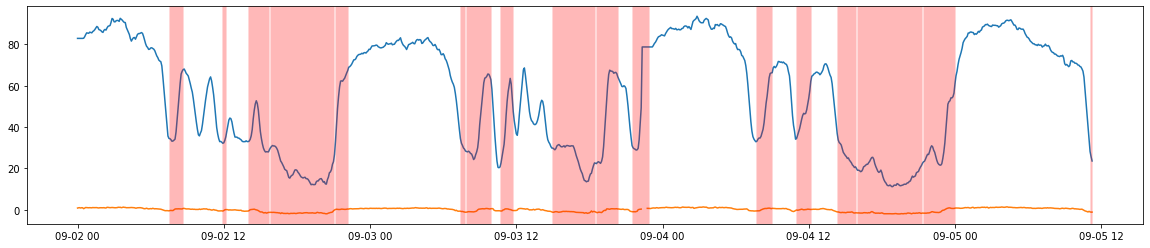

In [51]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:1000][target_sid])
plt.plot(df_agg_inflow[:1000][1])
# plt.plot(df_agg_outflow[:1000][1])

for i in range(1000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.2, color='r')

## multivariate profile

In [11]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(speed_all[inflow].mean(axis=1))
    df_agg_outflow.append(speed_all[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [12]:
## congestion threshold
ff_speed = speed_all.quantile(q=0.90, axis=0)
cong_speed = ff_speed * 0.6


## c1. incident road : s(v,t) < 0.6 * ff(v)
congestion_label = (speed_all[target_sid] < 0.6*cong_speed[target_sid])
## c2. 1hop incoming roads : s(v,t) < 0.6 * ff(v) for more than 50% of 1hop incoming
hop1 = np.unique([p[1] for p in path_inflow])
cong_hop1 = speed_all[hop1] < cong_speed[hop1]
propagation = cong_hop1.sum(axis=1) >= 0.5*cong_hop1.shape[1]
## c1 & c2
congestion_label = congestion_label & propagation
congestion_label = congestion_label.astype(int)
congestion_label = pd.DataFrame(congestion_label).rename({0:'RC'}, axis=1)

In [13]:
cong_hop1.sum(axis=1).value_counts()

0    24479
4     8112
1     7470
3     6694
2     5085
dtype: int64

In [14]:
congestion_label[congestion_label.RC == 1]

,RC
datetime,
2020-09-02 11:50:00,1
2020-09-02 11:55:00,1
2020-09-02 12:00:00,1
2020-09-02 15:10:00,1
2020-09-02 15:15:00,1
...,...
2021-02-28 22:40:00,1
2021-02-28 22:45:00,1
2021-02-28 22:50:00,1


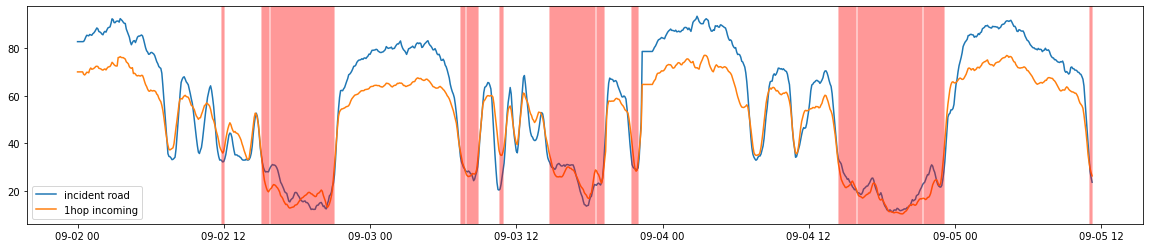

In [17]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:1000][target_sid], label='incident road')
plt.plot(df_agg_inflow[:1000][1], label='1hop incoming')
# plt.plot(speed_all[:1000][1210065700])
# plt.axhline(cong_speed[target_sid])
# plt.axhline(cong_speed[1210065700])
for i in range(1000):
    if congestion_label['RC'][i] == True:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')
plt.legend()

In [15]:
date_all = np.arange(datetime(2020,9,2), datetime(2021,2,1), timedelta(days=1))
len(date_all), date_all[:5]

(152,
 array(['2020-09-02T00:00:00.000000', '2020-09-03T00:00:00.000000',
        '2020-09-04T00:00:00.000000', '2020-09-05T00:00:00.000000',
        '2020-09-06T00:00:00.000000'], dtype='datetime64[us]'))

In [17]:
accident_case['created'] = pd.to_datetime(accident_case['created'])
date_incident = accident_case.created.apply(lambda s: s.date())
date_incident.values

/tmp/ipykernel_2721585/4091084093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


array([datetime.date(2020, 11, 22), datetime.date(2020, 11, 24),
       datetime.date(2020, 11, 24), datetime.date(2020, 11, 29),
       datetime.date(2020, 12, 6), datetime.date(2020, 12, 10),
       datetime.date(2020, 12, 15), datetime.date(2020, 12, 21),
       datetime.date(2020, 12, 23), datetime.date(2021, 1, 2),
       datetime.date(2021, 1, 4), datetime.date(2021, 1, 9),
       datetime.date(2021, 1, 10), datetime.date(2021, 1, 12),
       datetime.date(2021, 1, 25), datetime.date(2021, 1, 25),
       datetime.date(2021, 2, 13), datetime.date(2021, 2, 17),
       datetime.date(2021, 2, 21), datetime.date(2021, 2, 26)],
      dtype=object)

In [18]:
date_binary = np.zeros(len(date_all))
for i in range(len(date_all)):
    if date_all[i].astype(datetime).date() in date_incident.values:
        print(date_all[i])
        date_binary[i] = 1

2020-11-22T00:00:00.000000
2020-11-24T00:00:00.000000
2020-11-29T00:00:00.000000
2020-12-06T00:00:00.000000
2020-12-10T00:00:00.000000
2020-12-15T00:00:00.000000
2020-12-21T00:00:00.000000
2020-12-23T00:00:00.000000
2021-01-02T00:00:00.000000
2021-01-04T00:00:00.000000
2021-01-09T00:00:00.000000
2021-01-10T00:00:00.000000
2021-01-12T00:00:00.000000
2021-01-25T00:00:00.000000


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

#### Random CV

In [33]:
test_size = int(len(date_all) * 0.2)

train_X, test_X = train_test_split(date_all, test_size=test_size, random_state=0)
train_X, valid_X = train_test_split(train_X, test_size=test_size, random_state=0)

train_X.shape, valid_X.shape, test_X.shape

((92,), (30,), (30,))

#### K-fold CV

In [25]:
# kf = KFold(n_splits=5, random_state=None, shuffle=False)
# kf.get_n_splits(date_all)


kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(date_all, date_binary)

for i, (train_index, test_index) in enumerate(kf.split(date_all, date_binary)):
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print(date_binary[test_index])

    train_X = date_all[train_index]
    test_X = date_all[test_index]
    print(train_X.shape, test_X.shape)

5

#### Create Dataset

In [37]:
    X_all = []
    y_all = []
    for d in range(len(train_X)):
        tmp_df = speed_all[speed_all.index.date == train_X[d].astype(datetime).date()]
        tmp_label = congestion_label[congestion_label.index.date == train_X[d].astype(datetime).date()]
        for i in range(12, len(tmp_df)-12):
            if tmp_label['RC'][i] == 1:
                if tmp_label['NRC'][i] == 1:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(1)
                else:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(0)
            else:
                continue
    X_all = np.stack(X_all)
    y_all = np.stack(y_all)

    (y_all == 0).sum(), (y_all==1).sum(), (y_all==1).sum()/len(y_all)

(7104, 199, 0.0272490757223059)

In [38]:
    X_all = []
    y_all = []
    for d in range(len(valid_X)):
        tmp_df = speed_all[speed_all.index.date == valid_X[d].astype(datetime).date()]
        tmp_label = congestion_label[congestion_label.index.date == valid_X[d].astype(datetime).date()]
        for i in range(12, len(tmp_df)-12):
            if tmp_label['RC'][i] == 1:
                if tmp_label['NRC'][i] == 1:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(1)
                else:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(0)
            else:
                continue
    X_all = np.stack(X_all)
    y_all = np.stack(y_all)

    (y_all == 0).sum(), (y_all==1).sum(), (y_all==1).sum()/len(y_all)

(2232, 13, 0.005790645879732739)

In [39]:
    X_all = []
    y_all = []
    for d in range(len(test_X)):
        tmp_df = speed_all[speed_all.index.date == test_X[d].astype(datetime).date()]
        tmp_label = congestion_label[congestion_label.index.date == test_X[d].astype(datetime).date()]
        for i in range(12, len(tmp_df)-12):
            if tmp_label['RC'][i] == 1:
                if tmp_label['NRC'][i] == 1:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(1)
                else:
                    X_all.append(tmp_df.iloc[i-12:i+12, :])
                    y_all.append(0)
            else:
                continue
    X_all = np.stack(X_all)
    y_all = np.stack(y_all)

    (y_all == 0).sum(), (y_all==1).sum(), (y_all==1).sum()/len(y_all)

(2104, 57, 0.026376677464136973)

## Incident Data (congestion 비교)

In [14]:
ff_speed = speed_all.quantile(q=0.90, axis=0)
cong_speed = ff_speed * 0.6
ff_speed, cong_speed

(sid
 1210004801     79.404046
 1210004802     89.652873
 1210005304    104.137985
 1210005305    104.273915
 1210065700     71.094556
 1210066100     64.040266
 1210066300     59.616381
 1220004700     40.070247
 1220095000     52.945226
 1220096900     57.911081
 1220342100     48.404164
 1220342500    104.397419
 1220342700     78.759407
 1020026801     51.042692
 1020056400     77.492314
 1210004500     96.373359
 1210004901     94.733181
 1210004902     86.594552
 1210005402     98.090156
 1210060300     76.431230
 1210062100     39.620123
 1210062500     48.643593
 1210062700     68.107427
 1210158699     37.863541
 1210160799     36.484535
 1210005301     90.742726
 Name: 0.9, dtype: float64,
 sid
 1210004801    47.642427
 1210004802    53.791724
 1210005304    62.482791
 1210005305    62.564349
 1210065700    42.656734
 1210066100    38.424160
 1210066300    35.769829
 1220004700    24.042148
 1220095000    31.767136
 1220096900    34.746649
 1220342100    29.042499
 1220342500

In [103]:
## only incident road
## SAD
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12][target_sid]
    if ts.mean() < cong_speed[target_sid]:
        congestion_label.iloc[i+12] = 1

In [104]:
congestion_label['RC'].value_counts()

1    26176
0    25664
Name: RC, dtype: int64

In [20]:
## all roads
## original
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.2*speed_all.shape[1]:
        congestion_label.iloc[i+12] = 1

In [16]:
congestion_label['RC'].value_counts()

0    26716
1    25124
Name: RC, dtype: int64

In [17]:
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [18]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in speed_all.columns]
    outflow = [p for p in outflow if p in speed_all.columns]
    df_agg_inflow.append(speed_all[inflow].mean(axis=1))
    df_agg_outflow.append(speed_all[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [ ]:
## hop1 roads (cascading congestion)
## newnew
## average 1hop
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
hop1 = np.unique([p[1] for p in path_inflow])

for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    ts_hop = df_agg_inflow[i:i+12][1]
    # n_cong_road = (ts[hop1].mean(axis=0) < cong_speed[hop1]).sum()
    # if (ts[target_sid].mean() < cong_speed[target_sid]) & (n_cong_road > 0.5*len(hop1)):
    #     congestion_label.iloc[i+12] = 1
    if (ts[target_sid].mean() < cong_speed[target_sid]) & (ts_hop.mean() < df_agg_inflow[1].quantile(q=0.90) * 0.6 ):
        congestion_label.iloc[i+12] = 1

In [210]:
congestion_label['RC'].value_counts()

0    33864
1    17976
Name: RC, dtype: int64

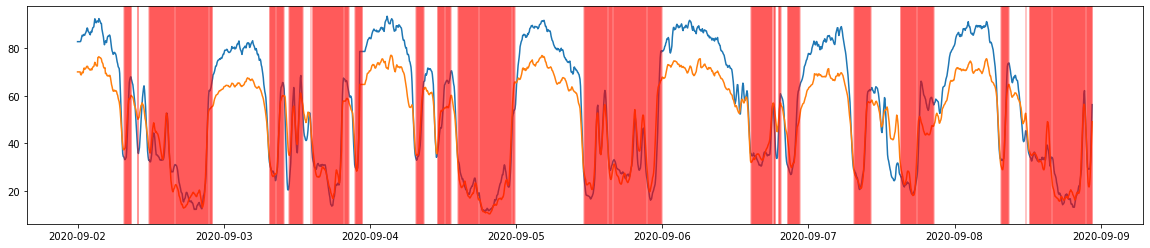

In [24]:
plt.figure(figsize=(20,4))
# plt.plot(speed_all[:1000][target_sid])
plt.plot(speed_all[:2000][target_sid])
plt.plot(df_agg_inflow[:2000][1])

for i in range(2000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

In [220]:
# ff_speed = df_all_norm.quantile(q=0.90, axis=0)
# cong_speed = ff_speed * 0.6

In [224]:
# df_agg_inflow, df_agg_outflow = [], []
# for hop in [0, 1, 2, 3]:
#     inflow = np.unique([p[hop] for p in path_inflow])
#     outflow = np.unique([p[hop] for p in path_outflow])
#     inflow = [p for p in inflow if p in df_all_norm.columns]
#     outflow = [p for p in outflow if p in df_all_norm.columns]
#     df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
#     df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
# df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
# df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [237]:
## hop1 roads (cascading congestion)
## newnew
## half 1hop
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
hop1 = np.unique([p[1] for p in path_inflow])

for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    # ts_hop = df_agg_inflow[i:i+12][1]
    n_cong_road = (ts[hop1].mean(axis=0) < cong_speed[hop1]).sum()
    if (ts[target_sid].mean() < cong_speed[target_sid]) & (n_cong_road > 0.5*len(hop1)):
        congestion_label.iloc[i+12] = 1
    # if (ts[target_sid].mean() < cong_speed[target_sid]) & (ts_hop.mean() < df_agg_inflow[1].quantile(q=0.90) * 0.6 ):
    #     congestion_label.iloc[i+12] = 1

In [238]:
congestion_label['RC'].value_counts()

0    37101
1    14739
Name: RC, dtype: int64

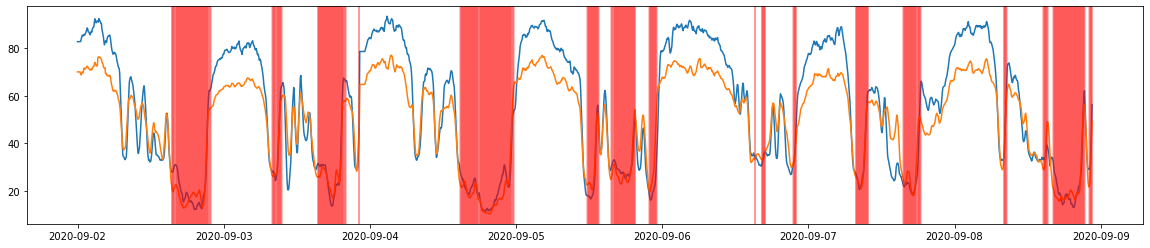

In [240]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:2000][target_sid])
plt.plot(df_agg_inflow[:2000][1])

for i in range(2000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

In [20]:
## all roads & recurrent time
## CLS
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if (n_cong_road > 0.5*speed_all.shape[1]) & (ts.index[0].hour in [7, 8, 9, 17, 18, 19]):
        congestion_label.iloc[i+12] = 1

/tmp/ipykernel_2721585/334160162.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


!!!
!!!
!!!


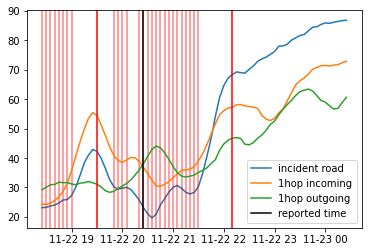

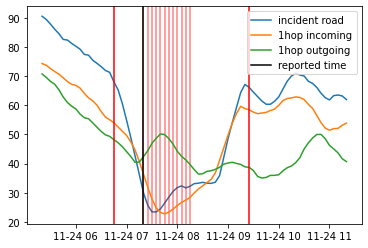

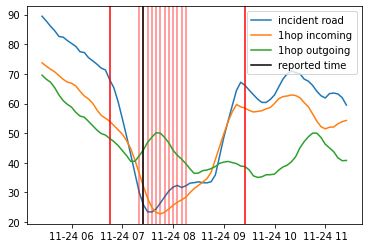

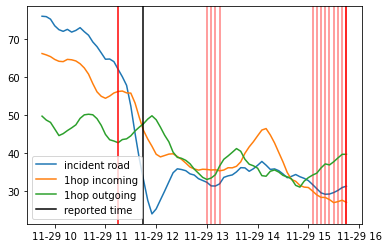

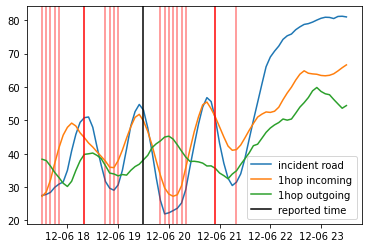

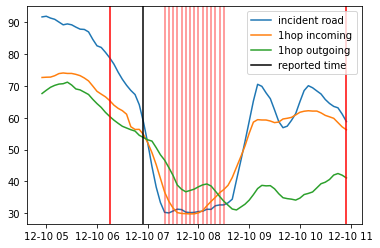

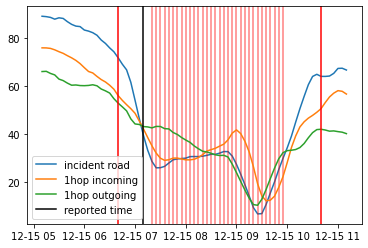

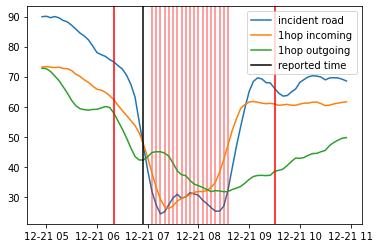

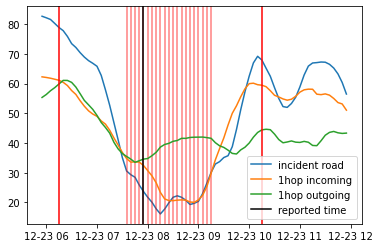

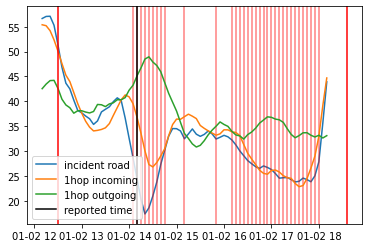

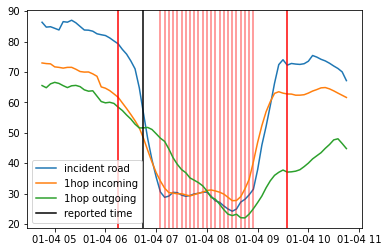

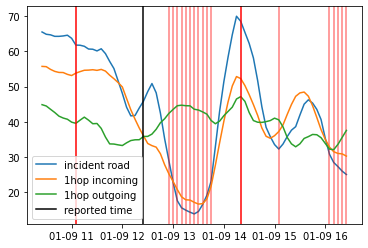

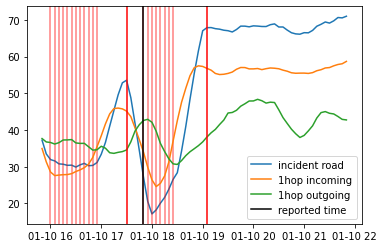

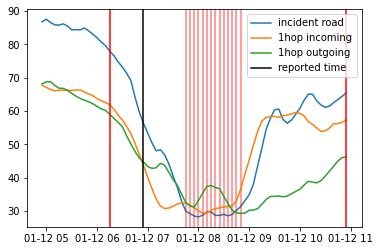

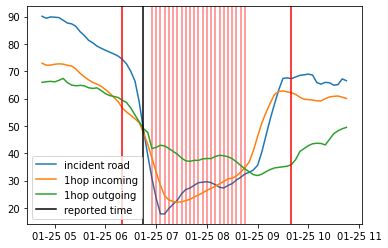

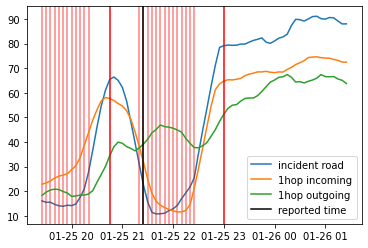

In [36]:
# label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
congestion_label['NRC'] = 0
cnt = 0
plot=True

## Incident Data Plot
accident_case['created'] = pd.to_datetime(accident_case['created'])

for ix, row in accident_case.iterrows():
    t = row['created']
    accident_sid = row['accident_sid']
#     if (t.month != 1) and (t.month != 12):
#         continue
    if (t.month == 2):
        continue

    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    accident_dt = accident_info[0]['created'].to_pydatetime()
    accident_dt = datetime.fromtimestamp(round(accident_dt.timestamp()/300)*300)
    accident_idx = np.where(df_all_norm.index == accident_dt)[0][0]
    df_pre = df_all_norm[accident_dt - timedelta(minutes=120):accident_dt]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    if len(congestion_start_list) == 0:
        congestion_start_time = accident_dt
    else:
        congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=60):accident_dt]
    zero_condition = pd.DataFrame(0, index=df_avg_pre_new.index, columns=df_avg_pre_new.columns)
    df_end_condition = (np.maximum(zero_condition.mean(), df_avg_pre_new.mean()) < df_all_norm)[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx+6 for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4)]
    if len(congestion_end_list) == 0:
        print("!!!")
        congestion_end_list = [accident_idx+12*4]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()



    ## traffic congestion condition (only incident road)
    dt_ = congestion_label[accident_dt+timedelta(minutes=-120):accident_dt+timedelta(minutes=240)].index
    plt.figure()
    plt.plot(speed_all[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid], label='incident road')
    for dt in dt_:
        if congestion_label.loc[dt, 'RC'] == 1:
            plt.axvline(dt, color='r', alpha=.5)




#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)

    # plt.figure()
    # plt.plot(df_all_norm[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid])
    plt.plot(df_agg_inflow[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][1], label='1hop incoming')
    plt.plot(df_agg_outflow[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][2], label='1hop outgoing')
    plt.axvline(congestion_start_time, color='red')
    plt.axvline(congestion_end_time, color='red')
    plt.axvline(accident_dt, color='k', label='reported time')
    plt.legend()
        
    cnt += 1
    ## Label generation
#     label_df[congestion_start_time:congestion_end_time] = 1
    congestion_label.loc[congestion_start_time:congestion_end_time, 'NRC'] = 1

    

In [27]:
def get_x_y(speed_df, label_df):
    X_all = []
    y_all = []
    for i in range(len(speed_df)-12):
        if (label_df['RC'][i+12] == 1) & (label_df['NRC'][i+12] == 1):
            X_all.append(speed_df.iloc[i:i+12, :])
            y_all.append(1)
        elif (label_df['RC'][i+12] == 1) & (label_df['NRC'][i+12] == 0):
            X_all.append(speed_df.iloc[i:i+12, :])
            y_all.append(0)
    X_all = np.stack(X_all)
    y_all = np.stack(y_all)
    
    return X_all, y_all

In [52]:
x_all, y_all = get_x_y(speed_all, congestion_label)

In [53]:
x_all.shape, y_all.shape
    

((25124, 12, 26), (25124,))

In [61]:
(y_all == 0).sum(), (y_all == 1).sum()

(24666, 458)

In [59]:
pd.DataFrame(y_all).value_counts()

0    24666
1      458
dtype: int64

2021-01-02 14:10:00
2021-01-04 06:46:00
2021-01-09 12:27:00
2021-01-10 17:52:00
2021-01-12 06:54:00
2021-01-25 06:46:00
2021-01-25 21:23:00


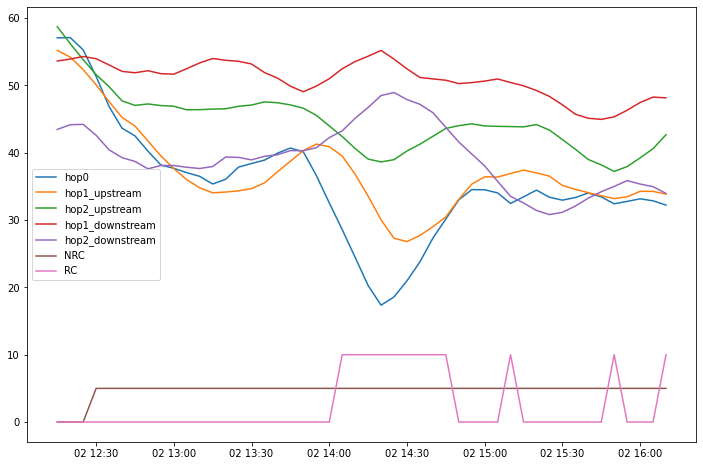

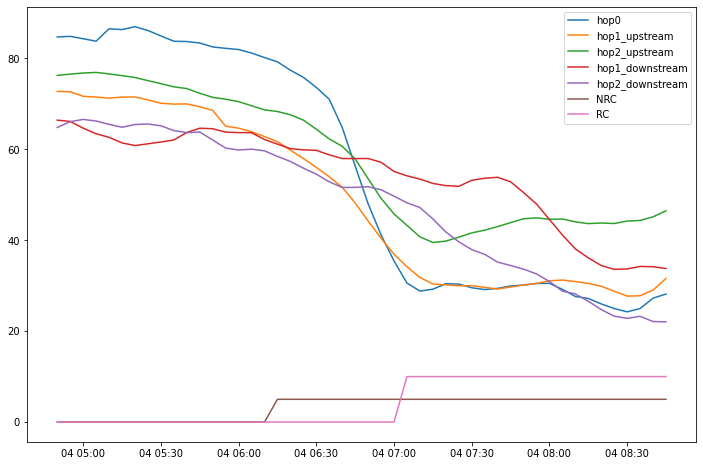

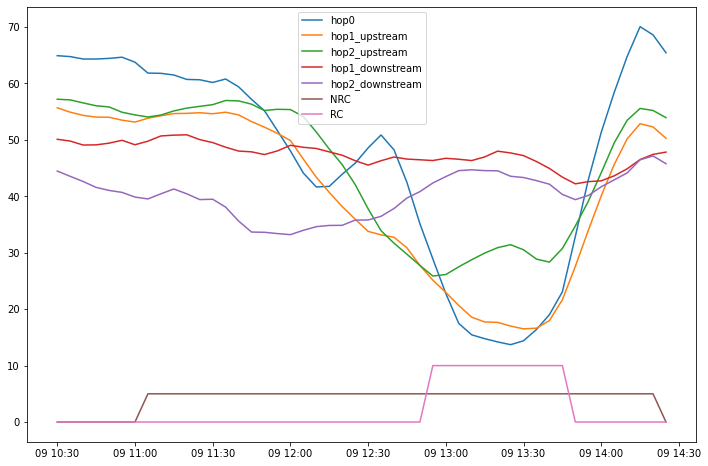

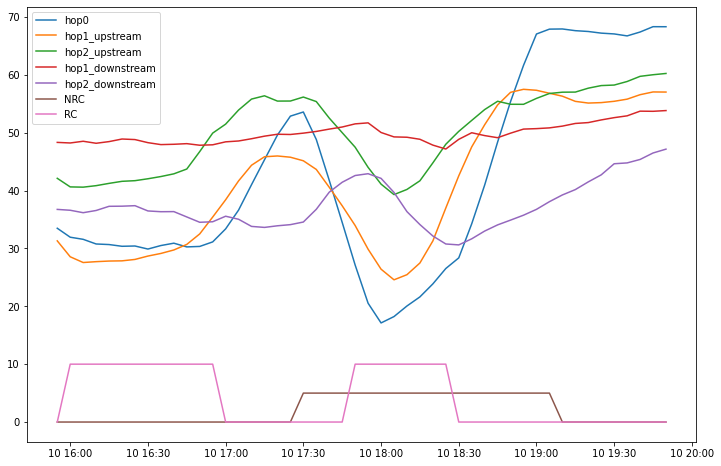

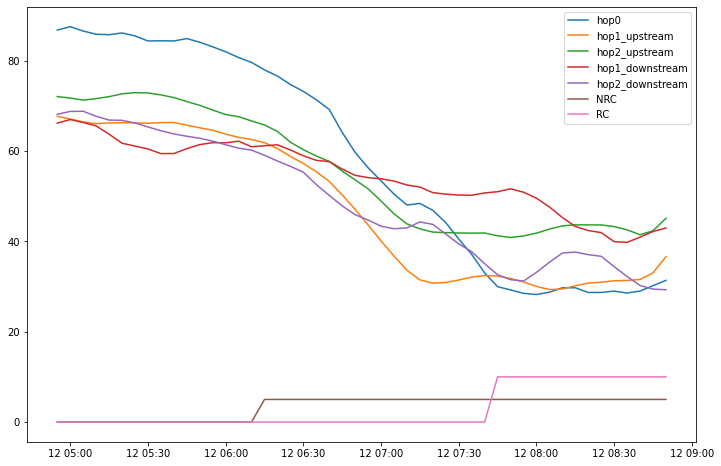

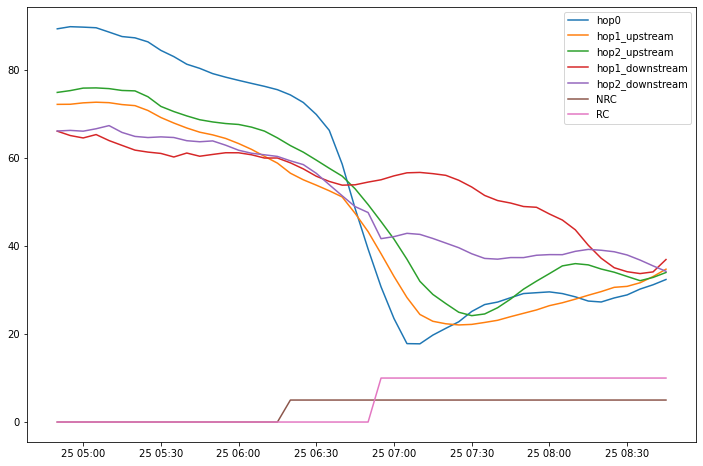

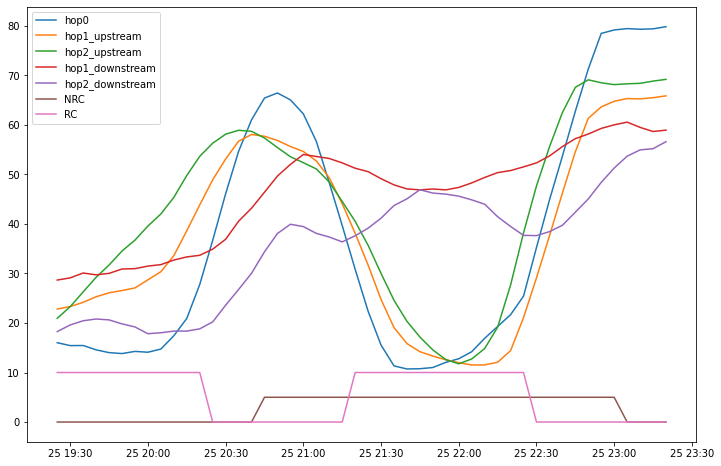

In [28]:
for ix, row in accident_case.iterrows():
#     t = datetime.strptime(row['created'], '%Y-%m-%d %H:%M:%S')
    t = row['created']
    # if (t.month != 12) and (t.month != 1):
    #     continue
    if (t.month > 1):
        continue
    print(t)
    
    t0 = (speed_all.index > t+timedelta(minutes=-120))
    t1 = (speed_all.index <= t+timedelta(minutes=120))
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow[t0&t1][0], label='hop0')
    plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream')
    plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream')
    plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream')
    plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream')
    plt.plot(congestion_label[t0&t1]['NRC']*5, label='NRC')
    plt.plot(congestion_label[t0&t1]['RC']*10, label='RC')
    plt.legend()

In [475]:
congestion_label['label'] = congestion_label['RC']

In [477]:
X_all = []
y_all = []
for i in range(len(speed_all)-12):
    if congestion_label.NRC[i+12] == 1:
        X_all.append(speed_all.iloc[i:i+12, :])
        y_all.append(1)
    elif congestion_label.RC[i+12] == 1:
        X_all.append(speed_all.iloc[i:i+12, :])
        y_all.append(0)
X_all = np.stack(X_all)
y_all = np.stack(y_all)

In [478]:
X_all.shape, y_all.shape

((10382, 12, 25), (10382,))

In [479]:
np.unique(y_all, return_counts = True) 

(array([0, 1]), array([9720,  662]))

In [486]:
# # Recurrent Congestion
# ## smoothing
# rolling_window = 6
# speed_all = df_all_norm.rolling(rolling_window).mean()

# ## nan value
# speed_all = speed_all.bfill(limit=36).ffill(limit=36).fillna(0, limit=288*10).dropna(axis=1)


ff_speed = df_all_norm.quantile(q=0.85, axis=0)
cong_speed = ff_speed * 0.6

congestion_label_test = pd.DataFrame(0, index=df_all_norm.index, columns=['RC'])
for i in range(len(df_all_norm)-12):
    ts = df_all_norm[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.5*df_all_norm.shape[1]:
        congestion_label_test.iloc[i+12] = 1

In [487]:
congestion_label_test['RC'].value_counts()

1    35751
0    16089
Name: RC, dtype: int64

## Congestion Pattern Clustering

In [171]:
## c1. incident road : s(v,t) < 0.6 * ff(v)
congestion_label = (speed_all[target_sid] < 0.6*cong_speed[target_sid])
## c2. 1hop incoming roads : s(v,t) < 0.6 * ff(v) for more than 50% of 1hop incoming
hop1 = np.unique([p[1] for p in path_inflow])
cong_hop1 = speed_all[hop1] < cong_speed[hop1]
propagation = cong_hop1.sum(axis=1) >= 0.5*cong_hop1.shape[1]
## c1 & c2
congestion_label = congestion_label & propagation
congestion_label = congestion_label.astype(int)
congestion_label = pd.DataFrame(congestion_label).rename({0:'RC'}, axis=1)

In [29]:
congestion_label

,RC,NRC
datetime,,
2020-09-02 00:00:00,0,0
2020-09-02 00:05:00,0,0
2020-09-02 00:10:00,0,0
2020-09-02 00:15:00,0,0
2020-09-02 00:20:00,0,0
...,...,...
2021-02-28 23:35:00,0,0
2021-02-28 23:40:00,0,0
2021-02-28 23:45:00,0,0


In [30]:
len(speed_all), len(congestion_label)

(51840, 51840)

In [32]:
congestion_speed_all = []
for i in range(12, len(speed_all)-12):
    if congestion_label.RC[i] == 1:
        congestion_speed_all.append(speed_all.iloc[i-12:i+12, :])
congestion_speed_all = np.stack(congestion_speed_all)
        

In [33]:
congestion_speed_all.shape

(14089, 24, 26)

In [34]:
from tslearn.clustering import TimeSeriesKMeans

n_cluster = 8

v0_ts_all = np.stack([s[:, -1] for s in congestion_speed_all])
v0_ts_all = np.expand_dims(v0_ts_all, axis=-1)
sz = v0_ts_all.shape[1]
km = TimeSeriesKMeans(n_clusters=n_cluster, verbose=True, random_state=0)
y_pred = km.fit_predict(v0_ts_all)



871.116 --> 622.312 --> 606.189 --> 602.438 --> 601.250 --> 600.732 --> 600.421 --> 600.206 --> 600.098 --> 600.019 --> 599.946 --> 599.875 --> 599.829 --> 599.793 --> 599.754 --> 599.724 --> 599.696 --> 599.668 --> 599.640 --> 599.611 --> 599.579 --> 599.542 --> 599.495 --> 599.464 --> 599.444 --> 599.426 --> 599.410 --> 599.396 --> 599.382 --> 599.370 --> 599.355 --> 599.335 --> 599.301 --> 599.234 --> 599.158 --> 599.074 --> 598.962 --> 598.841 --> 598.695 --> 598.559 --> 598.433 --> 598.331 --> 598.234 --> 598.176 --> 598.155 --> 598.140 --> 598.125 --> 598.115 --> 598.107 --> 598.100 --> 


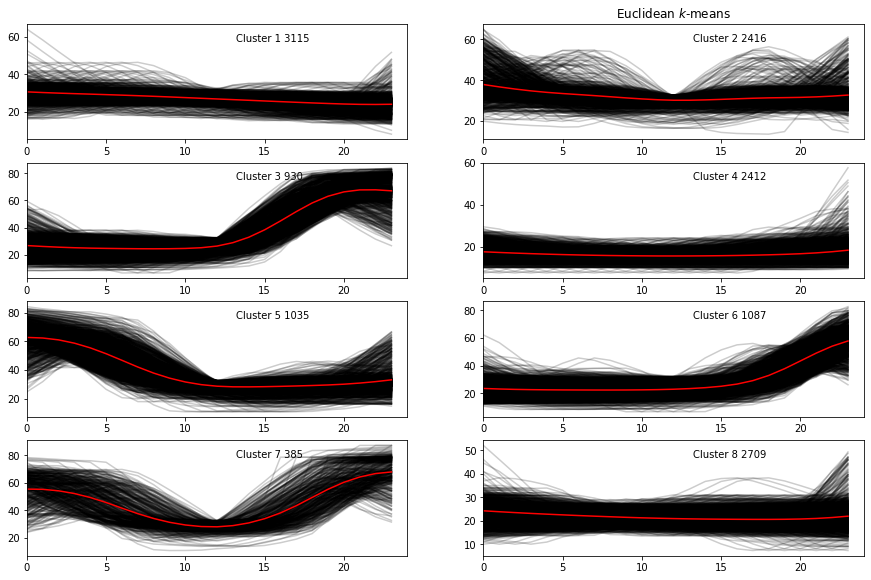

In [35]:
plt.figure(figsize=(15, int(5*n_cluster/2)))
for yi in range(n_cluster):
    plt.subplot(n_cluster, 2, yi + 1)
    for xx in v0_ts_all[y_pred == yi][:1000]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 24)
#     plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d %d' % (yi + 1, (y_pred == yi).sum()),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.show()

# Extra Incidents in Subgraph

In [19]:
accident_all
accident_case.shape

(20, 13)

In [47]:
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]

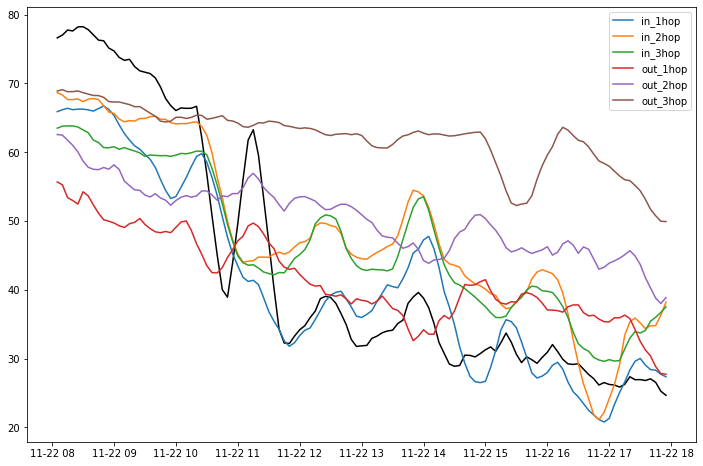

In [114]:
tmp = speed_all[(speed_all.index < datetime(2020, 11, 22, 18)) & (speed_all.index > datetime(2020,11,22,8))]
tmp_up = df_agg_inflow[(df_agg_inflow.index < datetime(2020, 11, 22,18)) & (df_agg_inflow.index > datetime(2020,11,22,8))]
tmp_out = df_agg_outflow[(df_agg_outflow.index < datetime(2020,11,22,18)) & (df_agg_outflow.index > datetime(2020,11,22,8))]
plt.figure(figsize=(12,8))
plt.plot(tmp[target_sid], color='k')
plt.plot(tmp_up[1], label='in_1hop')
plt.plot(tmp_up[2], label='in_2hop')
plt.plot(tmp_up[3], label='in_3hop')
plt.plot(tmp_out[2], label='out_1hop')
plt.plot(tmp_out[1], label='out_2hop')
plt.plot(tmp_out[0], label='out_3hop')
plt.legend()

In [20]:
tmp = []
for ix, row in accident_all.iterrows():
    if row['accident_sid'] in list(H.nodes):
        # print(row['accident_sid'])
        tmp.append(row)
        
accident_case_extra = pd.DataFrame(tmp)
accident_case_extra.head(7)

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
7,3686327,2020-09-28 22:31:00,2020-09-28 22:29:00,2020-09-28 22:49:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (반포대교 → 동작대교) 4차로 추돌사고로 정체,[1210004902],126.997591,37.509860,1210004902
260,3688292,2020-10-02 20:38:00,2020-10-02 20:37:00,2020-10-02 20:57:00,NaN,NaN,tbs 교통방송,ACCIDENT,경부고속도로 (부산 → 서울) 한남나들목부근 2차로 승용차관련 추돌사고로 양재나들목...,[1210004802],127.016209,37.516797,1210004802
192,3694804,2020-10-12 08:21:18,2020-10-12 08:19:00,2020-10-12 08:49:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 경부고속도로 반포IC 에서 잠원IC 방향 4차로 교통사고,[1210004802],127.017194,37.506841,1210004802
54,3727311,2020-11-13 13:37:00,2020-11-13 13:35:00,2020-11-13 13:55:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대교 하남방면 (반포대교 → 한남대교) 2차로 승용차관련 추돌사고로 정체,[1210005402],127.005848,37.514257,1210005402
40,3734832,2020-11-22 10:51:00,2020-11-22 10:48:00,2020-11-22 11:08:00,NaN,NaN,tbs 교통방송,ACCIDENT,"올림픽대로 (하남 → 공항) 한남대교 조금 지난 지점 3차로 승용차,화물차 추돌사고...",[1210005304],127.013586,37.521627,1210005304
41,3734942,2020-11-22 14:36:00,2020-11-22 14:35:00,2020-11-22 14:55:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차끼리 추돌사고로 또 다른 ...,[1210005304],127.013586,37.521627,1210005304
45,3735057,2020-11-22 20:24:00,2020-11-22 20:21:00,2020-11-22 20:41:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차끼리 추돌사고로 정체,[1210005301],127.006911,37.515645,1210005301


In [24]:
target_sid

1210005301

In [23]:
accident_case_extra.tail(20)

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
25,3762631,2020-12-23 07:54:00,2020-12-23 07:50:00,2020-12-23 08:10:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 3차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.006594,37.515446,1210005301
58,3767256,2020-12-30 10:18:00,2020-12-30 10:15:00,2020-12-30 10:35:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 하남방면 (반포대교 → 한남대교) 5차로 승용차관련 추돌사고로 정체,[1210005402],127.005916,37.514289,1210005402
139,3769104,2021-01-02 14:10:00,2021-01-02 14:07:00,2021-01-02 14:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 추돌사고 처리작업으로 정체,[1210005301],127.006685,37.515446,1210005301
22,3769581,2021-01-04 06:46:00,2021-01-04 06:44:00,2021-01-04 07:04:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 (하남 → 공항) 반포대교 조금 못 간 지점 2차로 승용차관련 추돌사고로 정체,[1210005301],127.003337,37.512870,1210005301
0,3773249,2021-01-09 12:27:00,2021-01-09 12:25:00,2021-01-09 12:45:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (동호대교 → 한남대교) 4차로에 있었던 승용차관련 추돌사고 처...,[1210005301],127.003834,37.513212,1210005301
26,3773252,2021-01-09 12:32:00,2021-01-09 12:31:00,2021-01-09 12:51:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 하남방면 (반포대교 → 한남대교) 1차로 승용차끼리 추돌사고로 서행,[1210005402],127.006527,37.514906,1210005402
10,3773254,2021-01-09 12:50:26,2021-01-09 12:38:00,2021-01-09 13:08:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 올림픽대로 반포대교 에서 한남대교 방향 1차로 교통사고 주의운전 서울청,[1210005402],127.006691,37.515023,1210005402
3,3773411,2021-01-09 16:43:00,2021-01-09 16:35:00,2021-01-09 16:55:00,NaN,NaN,tbs 교통방송,ACCIDENT,"올림픽대로 하남방면 (반포대교 → 한남대교) 2,3차로 승용차끼리 3중 추돌사고 처...",[1210005402],127.007545,37.515771,1210005402
167,3773701,2021-01-10 13:28:00,2021-01-10 13:26:00,2021-01-10 13:46:00,NaN,NaN,tbs 교통방송,ACCIDENT,경부고속도로 (부산 → 서울) 한남나들목 올림픽대로 공항방면 진입로 승용차관련 추돌...,[1210066100],127.017884,37.519662,1210066100
175,3773797,2021-01-10 17:52:00,2021-01-10 17:50:00,2021-01-10 18:10:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 1차로 추돌사고 처리작업으로 정체,[1210005301],127.007205,37.515874,1210005301


1210005402
1210005402
1210005402
1210066100
1210005304


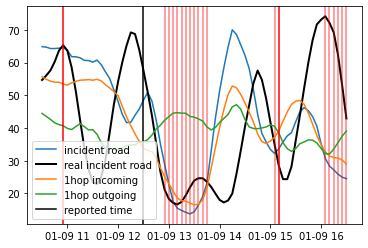

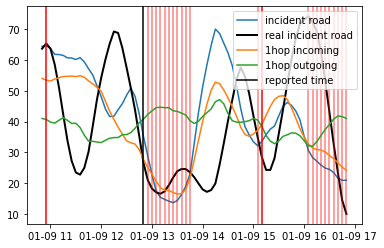

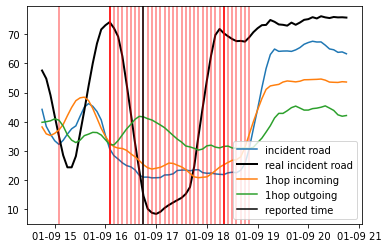

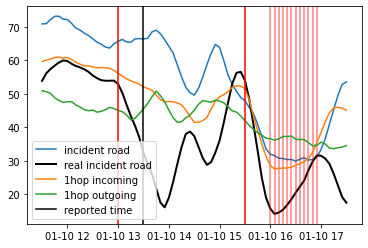

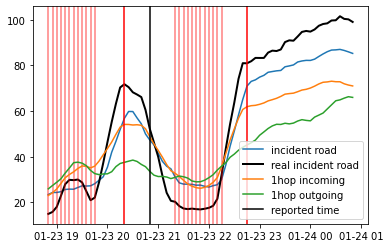

In [25]:
# label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
congestion_label['NRC'] = 0
cnt = 0
plot=True

## Incident Data Plot
accident_case_extra['created'] = pd.to_datetime(accident_case_extra['created'])

for ix, row in accident_case_extra.iterrows():
    t = row['created']
    accident_sid = row['accident_sid']
#     if (t.month != 1) and (t.month != 12):
#         continue
    # if (t.month == 2):
    if (t.month != 1):
        continue
    if accident_sid == target_sid:
        continue

    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    accident_dt = accident_info[0]['created'].to_pydatetime()
    accident_dt = datetime.fromtimestamp(round(accident_dt.timestamp()/300)*300)
    accident_idx = np.where(df_all_norm.index == accident_dt)[0][0]
    df_pre = df_all_norm[accident_dt - timedelta(minutes=120):accident_dt]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    if len(congestion_start_list) == 0:
        congestion_start_time = accident_dt
    else:
        congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=60):accident_dt]
    zero_condition = pd.DataFrame(0, index=df_avg_pre_new.index, columns=df_avg_pre_new.columns)
    df_end_condition = (np.maximum(zero_condition.mean(), df_avg_pre_new.mean()) < df_all_norm)[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx+6 for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4)]
    if len(congestion_end_list) == 0:
        print("!!!")
        congestion_end_list = [accident_idx+12*4]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()



    ## traffic congestion condition (only incident road)
    dt_ = congestion_label[accident_dt+timedelta(minutes=-120):accident_dt+timedelta(minutes=240)].index
    plt.figure()
    print(accident_sid)
    plt.plot(speed_all[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid], label='incident road')    
    plt.plot(speed_all[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][accident_sid], label='real incident road', color='k', lw=2)
    for dt in dt_:
        if congestion_label.loc[dt, 'RC'] == 1:
            plt.axvline(dt, color='r', alpha=.5)




#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)

    # plt.figure()
    # plt.plot(df_all_norm[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid])
    plt.plot(df_agg_inflow[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][1], label='1hop incoming')
    plt.plot(df_agg_outflow[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][2], label='1hop outgoing')
    plt.axvline(congestion_start_time, color='red')
    plt.axvline(congestion_end_time, color='red')
    plt.axvline(accident_dt, color='k', label='reported time')
    plt.legend()
        
    cnt += 1
    ## Label generation
#     label_df[congestion_start_time:congestion_end_time] = 1
    congestion_label.loc[congestion_start_time:congestion_end_time, 'NRC'] = 1

    